# The Google's 7 steps of Machine Learning in practice

This is a notebook for the medium article [The Google's 7 step of Machine Learning in Practice: a TensorFlow example for structured data](https://towardsdatascience.com/the-googles-7-steps-of-machine-learning-in-practice-a-tensorflow-example-for-structured-data-96ccbb707d77)

Please check out article for instructions

**License**: [BSD 2-Clause](https://opensource.org/licenses/BSD-2-Clause)


## Define the question
Data: [Titanic Dataset from Kaggle](https://www.kaggle.com/c/titanic/overview).

Let's pretend that we've been asked to create a system that predicts survival on the Titanic.

## 1. Gathering data
Let's import some libraries and load data to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start by reading in the CSV file into a pandas DataFrame.

**Note:** the test.csv from Kaggle doesn't come with source of truth (No Survived column).

Both the train.csv and test.csv we are using in this notebook are random shuffled and splited from the original train.csv

In [3]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [6]:
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

In [ ]:
df_train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


## 2. Preparing data with Exploratory Data Analysis (EDA)

Let's begin some exploratory data analysis! We'll start by checking out missing data!

### 2.1 Missing data

We can use seaborn to create a simple heatmap to see where we are missing data!

<Axes: >

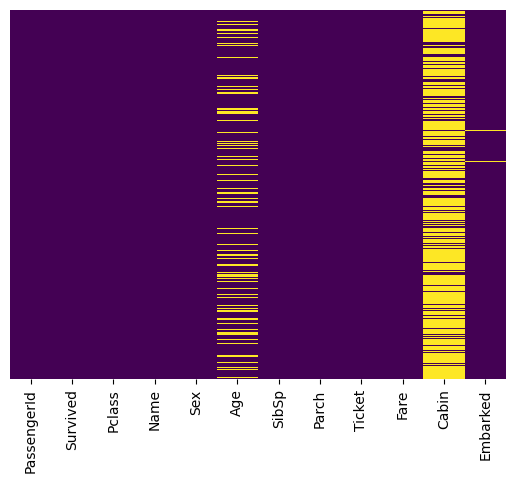

In [7]:
sns.heatmap(df_train_raw.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='viridis')

Age, Cabin and Embarked have missing values

Let's continue on by visualizing some more of the data!

<Axes: xlabel='Survived', ylabel='count'>

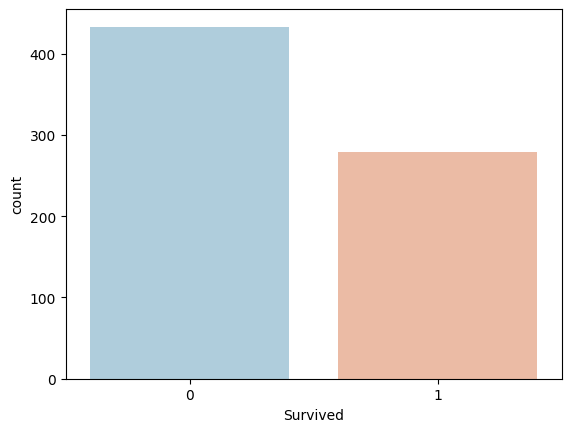

In [8]:
sns.countplot(x='Survived', data=df_train_raw, palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

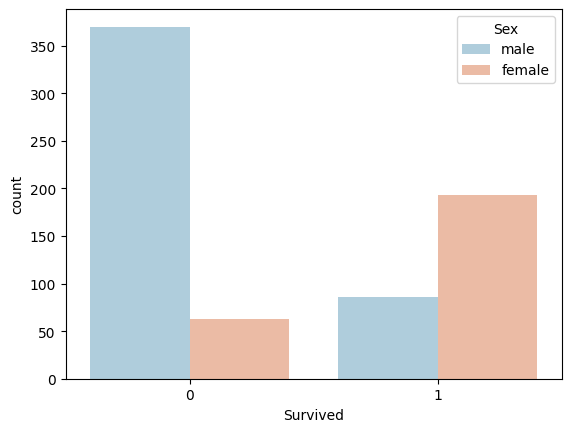

In [9]:
sns.countplot(x='Survived',
              hue='Sex',
              data=df_train_raw,
              palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

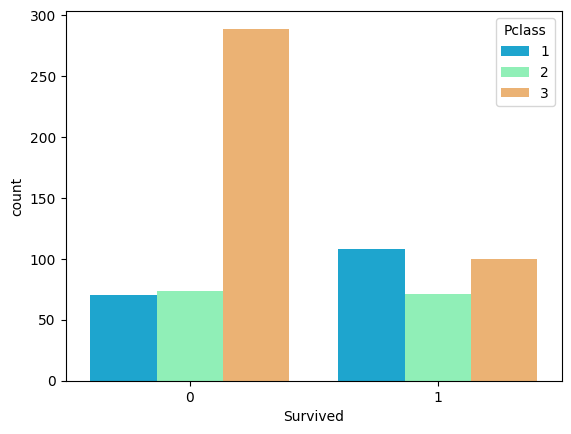

In [10]:
sns.countplot(x='Survived',
              hue='Pclass',
              data=df_train_raw,
              palette='rainbow')

<ipython-input-12-3d55b92552cc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train_raw['Age'].dropna(),


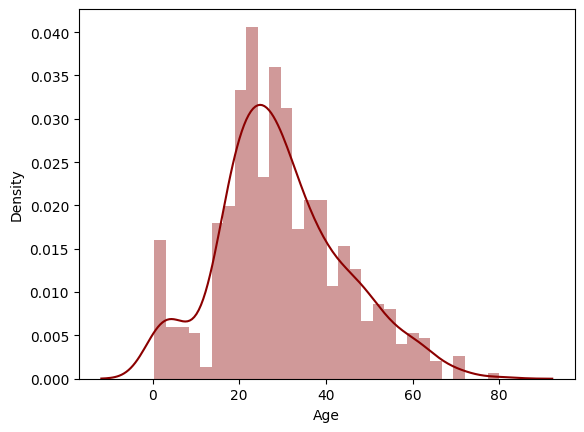

In [12]:
sns.distplot(df_train_raw['Age'].dropna(),
             kde=True,
             color='darkred',
             bins=30);

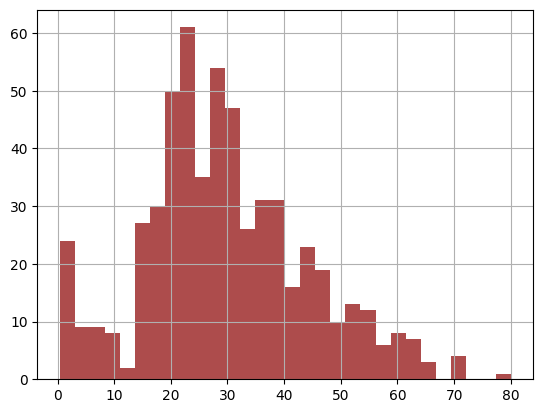

In [13]:
df_train_raw['Age'].hist(bins=30,color='darkred',alpha=0.7);

<Axes: xlabel='SibSp', ylabel='count'>

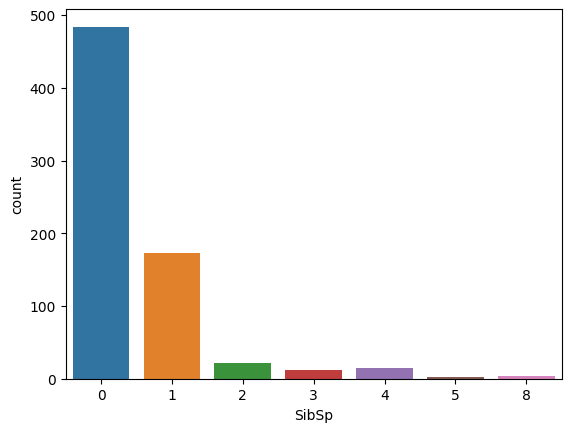

In [14]:
sns.countplot(x='SibSp',data=df_train_raw)

<Axes: >

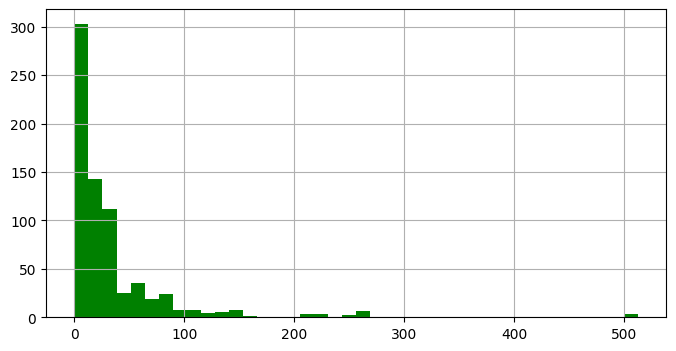

In [15]:
df_train_raw['Fare'].hist(color='green',
                          bins=40,
                          figsize=(8,4))

### 2.2 Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).

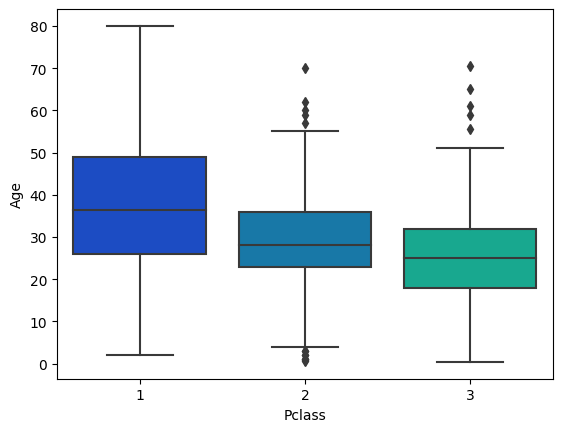

In [16]:
sns.boxplot(x='Pclass',
            y='Age',
            data=df_train_raw,
            palette='winter');

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [22]:
df_train_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [26]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now apply that function and check if it works

In [24]:
train_copy = df_train_raw.copy() # For test only
train_copy[['Age','Pclass']]

,Age,Pclass
0,55.0,1
1,49.0,1
2,36.0,2
3,19.0,2
4,14.0,3
...,...,...
707,24.0,3
708,NaN,1
709,45.0,3
710,35.0,2


In [27]:
train_copy[['Age','Pclass']].apply(impute_age, axis=1)

0      55.0
1      49.0
2      36.0
3      19.0
4      14.0
       ... 
707    24.0
708    37.0
709    45.0
710    35.0
711    37.0
Length: 712, dtype: float64

In [28]:
train_copy = df_train_raw.copy() # For test only
train_copy['Age'] = train_copy[['Age','Pclass']].apply(impute_age, axis=1)

Now let's check that heat map again!

<Axes: >

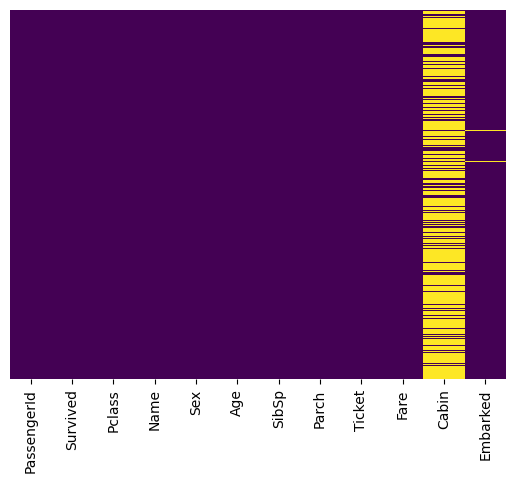

In [29]:
sns.heatmap(train_copy.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead

## Converting Categorical Features

We'll need to convert categorical features to one-hot encoding! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [30]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          566 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


In [32]:
df_train_raw['Pclass']

0      1
1      1
2      2
3      2
4      3
      ..
707    3
708    1
709    3
710    2
711    1
Name: Pclass, Length: 712, dtype: int64

In [33]:
pd.get_dummies(df_train_raw['Pclass'])   #Convert categorical variable into dummy/indicator variables.

,1,2,3
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,0,1
...,...,...,...
707,0,0,1
708,1,0,0
709,0,0,1
710,0,1,0


In [36]:
pclass = pd.get_dummies(df_train_raw['Pclass'])
pclass.columns = ['Pclass_' + str(x) for x in pclass.columns ]
pclass, pclass.columns

(     Pclass_1  Pclass_2  Pclass_3
 0           1         0         0
 1           1         0         0
 2           0         1         0
 3           0         1         0
 4           0         0         1
 ..        ...       ...       ...
 707         0         0         1
 708         1         0         0
 709         0         0         1
 710         0         1         0
 711         1         0         0
 
 [712 rows x 3 columns],
 Index(['Pclass_1', 'Pclass_2', 'Pclass_3'], dtype='object'))

In [37]:
 dfresult = pd.DataFrame()
 dfresult = pd.concat([dfresult, pclass],axis = 1)

 dfresult.head()

,Pclass_1,Pclass_2,Pclass_3
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,0,1


In [38]:
def preprocessing(df):

    dfresult = pd.DataFrame()

    # Let's keep features in the original order

    # Pclass -> one-hot encoding
    pclass = pd.get_dummies(df['Pclass'])
    pclass.columns = ['Pclass_' + str(x) for x in pclass.columns ]
    dfresult = pd.concat([dfresult, pclass],axis = 1)

    # Sex -> one-hot encoding
    sex = pd.get_dummies(df['Sex'])
    dfresult = pd.concat([dfresult,sex],axis = 1)

    # Age -> replace with imputation
    dfresult['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

    # SibSp, Parch, Fare
    dfresult['SibSp'] = df['SibSp']
    dfresult['Parch'] = df['Parch']
    dfresult['Fare'] = df['Fare']

    # Embarked -> one-hot encoding
    embarked = pd.get_dummies(df['Embarked'],dummy_na=True)
    embarked.columns = ['Embarked_' + str(x) for x in embarked.columns]
    dfresult = pd.concat([dfresult, embarked],axis = 1)

    return dfresult

In [40]:
df_train_raw['Survived'].values

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,

In [41]:
x_train = preprocessing(df_train_raw)
y_train = df_train_raw['Survived'].values

x_test = preprocessing(df_test_raw)
y_test = df_test_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 13)
x_test.shape = (179, 13)


In [43]:
x_train.head()

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,30.5000,0,0,1,0
1,1,0,0,1,0,49.0,1,0,76.7292,1,0,0,0
2,0,1,0,1,0,36.0,0,0,13.0000,0,0,1,0
3,0,1,0,0,1,19.0,0,0,13.0000,0,0,1,0
4,0,0,1,0,1,14.0,4,1,39.6875,0,0,1,0


Great! Our data is ready for our model!

## 3. Choose a model

Usually there are three ways of modeling using APIs of Keras.

Here we take the simplest way: sequential modeling using function Sequential().

In [44]:
import tensorflow as tf
from tensorflow.keras import models, layers

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(10,activation = 'relu',input_shape=(13,)))
model.add(layers.Dense(20,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                140       
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 381 (1.49 KB)
Trainable params: 381 (1.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. Training

Let's configure modle using `model.compile`

There are three ways for model training. Here we introduce the simplest way: using internal function fit.

In [45]:
# Convert dataframe data into np array
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# Get around with KMP duplicate issue
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Use binary cross entropy loss function for binary classification
model.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2
                   )

Epoch 1/30
9/9 [==============================] - 1s 32ms/step - loss: 1.3985 - accuracy: 0.5413 - val_loss: 0.8968 - val_accuracy: 0.6294
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 0.7927 - accuracy: 0.6274 - val_loss: 0.6617 - val_accuracy: 0.6923
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 0.7470 - accuracy: 0.6204 - val_loss: 0.6899 - val_accuracy: 0.7063
Epoch 4/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6658 - accuracy: 0.6907 - val_loss: 0.6991 - val_accuracy: 0.6573
Epoch 5/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6497 - accuracy: 0.6678 - val_loss: 0.6510 - val_accuracy: 0.6853
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 0.6803 - accuracy: 0.6608 - val_loss: 0.6887 - val_accuracy: 0.6224
Epoch 7/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6154 - accuracy: 0.7030 - val_loss: 0.6563 - val_accuracy: 0.6853
Epoch 8/30
9/9 [=================

## 5. Model Evaluation

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

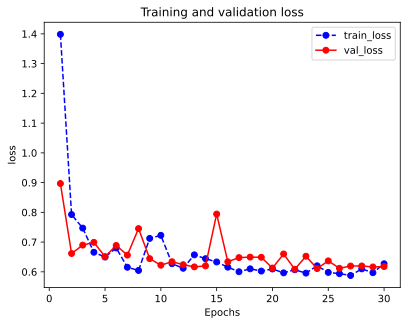

In [47]:
plot_metric(history,"loss")


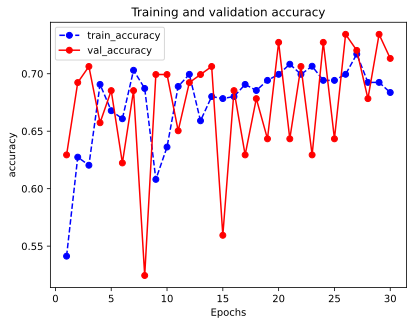

In [48]:
plot_metric(history,"accuracy")

In [49]:
# Run against test dataset

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6648


[0.6044895648956299, 0.6648044586181641]

## 6. Hyperparameter tuning

Let's use tensorboard hparams for hyperparameter tuning

In [50]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [51]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [52]:
# Import the TensorBoard HParams plugin:
from tensorboard.plugins.hparams import api as hp

In [54]:
hp.HParam('num_units_one', hp.Discrete([5, 10, 20]))

HParam(name='num_units_one', domain=Discrete([5, 10, 20]), display_name=None, description=None)

In [55]:
hp.HParam('num_units_two', hp.Discrete([10, 20, 40]))

HParam(name='num_units_two', domain=Discrete([10, 20, 40]), display_name=None, description=None)

In [56]:
hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

HParam(name='optimizer', domain=Discrete(['adam', 'sgd']), display_name=None, description=None)

In [53]:
HP_NUM_UNITS_ONE = hp.HParam('num_units_one', hp.Discrete([5, 10, 20]))
HP_NUM_UNITS_TWO = hp.HParam('num_units_two', hp.Discrete([10, 20, 40]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_ONE, HP_NUM_UNITS_TWO, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [57]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential()
  model.add(layers.Dense(hparams[HP_NUM_UNITS_ONE], activation = 'relu',input_shape=(13,)))
  model.add(layers.Dense(hparams[HP_NUM_UNITS_TWO],activation = 'relu' ))
  model.add(layers.Dense(1,activation = 'sigmoid' ))
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(x_train, y_train, epochs=30)
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [58]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [59]:
session_num = 0

for num_units_one in HP_NUM_UNITS_ONE.domain.values:
  for num_units_two in HP_NUM_UNITS_TWO.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS_ONE: num_units_one,
          HP_NUM_UNITS_TWO: num_units_two,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('>> Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

>> Starting trial: run-0
{'num_units_one': 5, 'num_units_two': 10, 'optimizer': 'adam'}
Epoch 1/30
23/23 [==============================] - 1s 4ms/step - loss: 2.6314 - accuracy: 0.5365
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 1.7890 - accuracy: 0.3961
Epoch 3/30
23/23 [==============================] - 0s 4ms/step - loss: 1.1860 - accuracy: 0.6404
Epoch 4/30
23/23 [==============================] - 0s 4ms/step - loss: 0.8823 - accuracy: 0.6657
Epoch 5/30
23/23 [==============================] - 0s 4ms/step - loss: 0.7408 - accuracy: 0.6728
Epoch 6/30
23/23 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.6770
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6812
Epoch 8/30
23/23 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6770
Epoch 9/30
23/23 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6812
Epoch 10/30
23/23 [===========

### Visualize the results in TensorBoard’s HParams plugin
Open your terminal, and cd into your project, then run `tensorboard --logdir logs/hparam_tuning`

Please refer to medium article for the details

## 7. Prediction

In [60]:
model.predict(x_test[0:10])

1/1 [==============================] - 0s 90ms/step


array([[0.54838496],
       [0.40523818],
       [0.5521696 ],
       [0.95178616],
       [0.5540213 ],
       [0.37585786],
       [0.5146127 ],
       [0.60907644],
       [0.73706967],
       [0.29260284]], dtype=float32)

In [61]:
model.predict_classes(x_test[0:10])

AttributeError: ignored

### Save model

In [62]:
model.save('data/keras_model.h5')

del model  # Deleting current model

# Identical to the previous one
model = models.load_model('data/keras_model.h5')
model.evaluate(x_test,y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6648


[0.6044895648956299, 0.6648044586181641]

## That's it

Thanks for reading

This is a notebook for the medium article [The Google's 7 step of Machine Learning in Practice: a TensorFlow example for structured data](https://towardsdatascience.com/the-googles-7-steps-of-machine-learning-in-practice-a-tensorflow-example-for-structured-data-96ccbb707d77)

Please check out article for instructions